In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/images'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

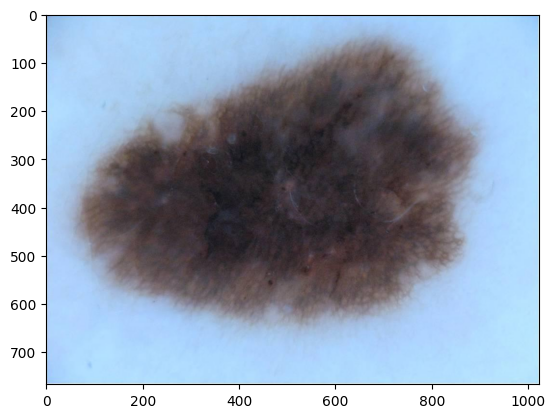

In [2]:
import matplotlib.pyplot  as plt
img = '/kaggle/input/all-isic-data-20240629/images/ISIC_0000000.jpg'
Image = plt.imread(img)
image = plt.imshow(Image)
plt.show()

In [3]:
import pandas as pd
df = pd.read_csv('/kaggle/input/all-isic-data-20240629/metadata.csv',usecols=["isic_id", "patient_id", "benign_malignant"],)


In [4]:
df.shape
df.columns

Index(['isic_id', 'benign_malignant', 'patient_id'], dtype='object')

In [14]:
# cài đặt thư viện
! pip install keras_cv
! pip install keras_cv_attention_models
!pip install tensorflow
%pip install tensorflow-hub
%pip install keras-cv


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [15]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models


In [16]:
Xtrain = df[['isic_id', 'patient_id']]
ytrain = df['benign_malignant']

# Split the data into training validation and test sets
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [17]:
print(f"Original data shape: {df.shape}")
print(f"Training set shape: {X_train.shape}")
print(f"Prediction set shape: {X_val.shape}")
print(f"Testing set shape: {X_test.shape}")

Original data shape: (81722, 3)
Training set shape: (65377, 2)
Prediction set shape: (8172, 2)
Testing set shape: (8173, 2)


In [18]:



# load convnext model 
# load convnext model using tf.keras.applications
base = tf.keras.applications.ConvNeXtBase(
    weights=None, include_top=False, input_shape=(224, 224, 3)
)

# Freeze the base model
base.trainable = False

# Add custom classification head
inputs = keras.Input(shape=(224, 224, 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)


I0000 00:00:1751439400.211738      35 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [19]:

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convnext_base (Functional)           │ (None, 7, 7, 1024)          │      87,566,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,617,089 (338.05 MB)

 Trainable params: 1,050,625 (4.01 MB)

 Non-trainable params: 87,566,464 (334.04 MB)

In [20]:

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=10, batch_size=32)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Convert predictions to binary labels
y_pred_labels = (y_pred > 0.5).astype(int)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred_labels)) 

ValueError: Invalid dtype: object